SNR = -25 dB | U1-Pd = 0.036 | U2-Pd = 0.036 | OMA-Pd = 0.036
ML Results: RF-Pd = 0.108, LR-Pd = 0.077, DT-Pd = 0.108, XGB-Pd = 0.101, SVM-Pd = 0.100

SNR = -24 dB | U1-Pd = 0.036 | U2-Pd = 0.036 | OMA-Pd = 0.036
ML Results: RF-Pd = 0.091, LR-Pd = 0.099, DT-Pd = 0.097, XGB-Pd = 0.088, SVM-Pd = 0.101

SNR = -23 dB | U1-Pd = 0.037 | U2-Pd = 0.037 | OMA-Pd = 0.037
ML Results: RF-Pd = 0.112, LR-Pd = 0.099, DT-Pd = 0.106, XGB-Pd = 0.104, SVM-Pd = 0.104

SNR = -22 dB | U1-Pd = 0.037 | U2-Pd = 0.037 | OMA-Pd = 0.037
ML Results: RF-Pd = 0.125, LR-Pd = 0.101, DT-Pd = 0.101, XGB-Pd = 0.107, SVM-Pd = 0.092

SNR = -21 dB | U1-Pd = 0.038 | U2-Pd = 0.038 | OMA-Pd = 0.037
ML Results: RF-Pd = 0.096, LR-Pd = 0.104, DT-Pd = 0.097, XGB-Pd = 0.086, SVM-Pd = 0.106

SNR = -20 dB | U1-Pd = 0.039 | U2-Pd = 0.039 | OMA-Pd = 0.038
ML Results: RF-Pd = 0.128, LR-Pd = 0.108, DT-Pd = 0.106, XGB-Pd = 0.096, SVM-Pd = 0.116

SNR = -19 dB | U1-Pd = 0.040 | U2-Pd = 0.040 | OMA-Pd = 0.039
ML Results: RF-Pd = 0.092, LR-Pd

ValueError: 'orange-o' is not a valid format string (unrecognized character 'a')

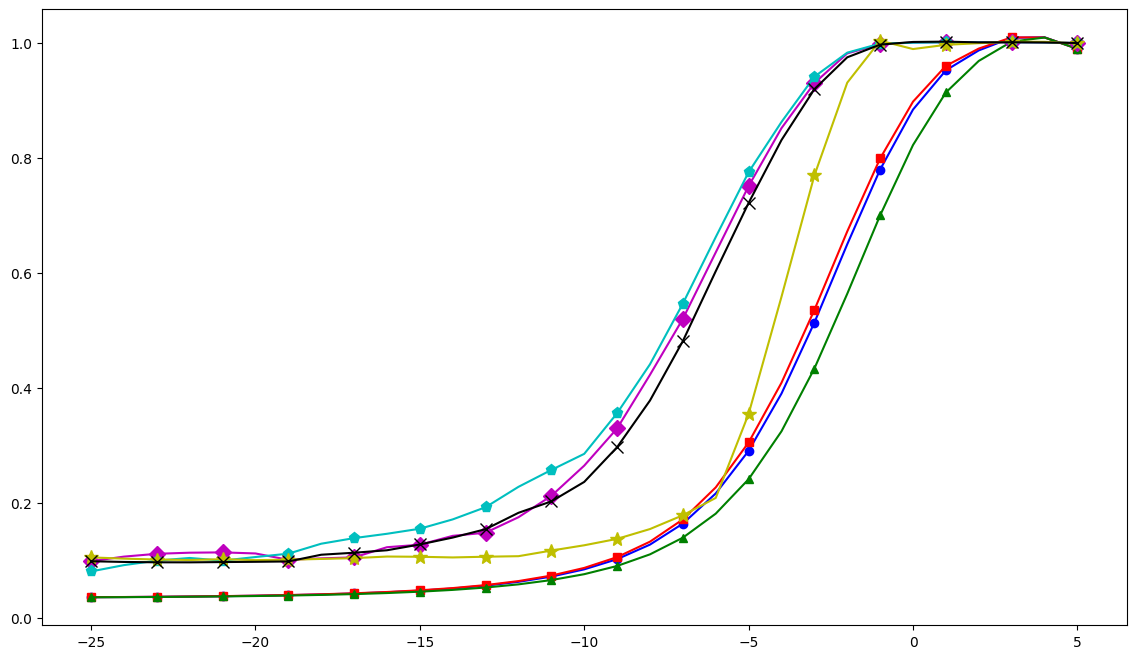

In [ ]:

# ---------------------
# 1) System Parameters
# ---------------------
SNR_dB = np.arange(-25, 6, 1)  # SNR range in dB
SNR_linear = 10 ** (SNR_dB / 10)

# Channel gains
h_u1_2 = 0.65
h_u2_2 = 2.7
h_oma_2 = 0.45

# Power allocation
alpha1 = 0.8
alpha2 = 0.2

# Detection parameters
Ns = 50
sigma_n2 = 1.0
alpha_cyclic = 0.1 # Dekho 
Pf_u1 = Pf_u2 = Pf_oma = 0.10
M1, M2 = 2, 2

# Monte Carlo parameters
num_samples = 10000

# Machine learning parameters
test_size = 0.2

# Cyclic lags for CAF
cyclic_lags = [18, 15]

# -------------------------------------------------
# 2) Cyclic Correlation Detection Functions
# -------------------------------------------------
def compute_cyclic_threshold(Pf, Ns, sigma_n2):
    return np.sqrt(2 * sigma_n2 / Ns) * norm.ppf(1 - Pf)

def cyclic_correlation_pd(SNR, alpha, h_2, Ns, lambda_val, sigma_n2, alpha_cyclic):
    signal_power = alpha * h_2 * SNR
    var_cyclic_H1 = (sigma_n2 + signal_power)**2 / Ns
    return 1 - norm.cdf((lambda_val - signal_power) / np.sqrt(var_cyclic_H1))


# -------------------------------------------------
# 3) ML Classifiers Setup
# -------------------------------------------------
def extract_features(received_signal):
    mag = np.abs(received_signal)
    
    # CAF features
    caf_values = []
    for lag in cyclic_lags:
        if lag < Ns:
            caf = np.mean(received_signal[:-lag] * np.conj(received_signal[lag:]))
            caf_values.append(np.abs(caf))
    caf_peak = max(caf_values) if caf_values else 0.0
    caf_variance = np.var(caf_values) if len(caf_values) > 1 else 0.0
    
    # Signal power estimate
    signal_power = max(np.mean(mag ** 2) - sigma_n2, 0)
    
    # Statistical features
    mag_kurtosis = kurtosis(mag)
    mag_skewness = skew(mag)
    
    return [
        np.mean(mag),
        np.std(mag),
        np.sum(mag ** 2),
        np.percentile(mag, 25),
        np.percentile(mag, 75),
        caf_peak,
        caf_variance,
        signal_power,
        mag_kurtosis,
        mag_skewness,
    ]

def generate_ml_data(snr_lin, num_samples):
    X, y = [], []

    for _ in range(num_samples):
        signal_present = np.random.rand() > 0.5

        if signal_present:
            x_u1 = np.sqrt(alpha1 * h_u1_2 * snr_lin) * np.random.randn(Ns)
            x_u2 = np.sqrt(alpha2 * h_u2_2 * snr_lin) * np.random.randn(Ns)
            signal = x_u1 + x_u2
        else:
            signal = np.zeros(Ns)

        noise = np.sqrt(sigma_n2 / 2) * (np.random.randn(Ns) + 1j * np.random.randn(Ns))
        received = signal + noise

        features = extract_features(received)
        X.append(features)
        y.append(signal_present)

    return np.array(X), np.array(y)

def train_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
        'SVM': SVC(probability=True, random_state=42)
    }

    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_probs = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        results[name] = (fpr, tpr, roc_auc)

    return results


# -------------------------------------------------
# 4) Main Simulation
# -------------------------------------------------
Pd_u1, Pd_u2, Pd_oma = [], [], []
Pd_rf, Pd_lr, Pd_dt, Pd_xgb, Pd_svm = [], [], [], [], []

for idx, snr_db in enumerate(SNR_dB):
    snr_lin = SNR_linear[idx]

    # Compute thresholds for cyclic correlation detection
    lambda_noma = compute_cyclic_threshold(Pf_u1, Ns, sigma_n2)
    lambda_oma = compute_cyclic_threshold(Pf_oma, Ns, sigma_n2)

    pd_u1 = cyclic_correlation_pd(snr_lin, alpha1, h_u1_2, Ns, lambda_noma, sigma_n2, alpha_cyclic)
    pd_u2 = cyclic_correlation_pd(snr_lin, alpha2, h_u2_2, Ns, lambda_noma, sigma_n2, alpha_cyclic)
    pd_oma = cyclic_correlation_pd(snr_lin, 1.0, h_oma_2, Ns, lambda_oma, sigma_n2, alpha_cyclic)

    X, y = generate_ml_data(snr_lin, num_samples)
    results = train_classifiers(X, y)

    fpr_desired = 0.10
    pd_results = {}

    for name, (fpr, tpr, _) in results.items():
        if max(fpr) >= fpr_desired:
            interp_tpr = interp1d(fpr, tpr)
            pd_results[name] = float(interp_tpr(fpr_desired))
        else:
            pd_results[name] = 1.0

    Pd_u1.append(pd_u1)
    Pd_u2.append(pd_u2)
    Pd_oma.append(pd_oma)
    Pd_rf.append(pd_results.get('Random Forest', 0))
    Pd_lr.append(pd_results.get('Logistic Regression', 0))
    Pd_dt.append(pd_results.get('Decision Tree', 0))
    Pd_xgb.append(pd_results.get('XGBoost', 0))
    Pd_svm.append(pd_results.get('SVM', 0))

    print(f"SNR = {snr_db:3d} dB | U1-Pd = {pd_u1:.3f} | U2-Pd = {pd_u2:.3f} | OMA-Pd = {pd_oma:.3f}")
    print(f"ML Results: RF-Pd = {pd_results['Random Forest']:.3f}, LR-Pd = {pd_results['Logistic Regression']:.3f}, DT-Pd = {pd_results['Decision Tree']:.3f}, XGB-Pd = {pd_results['XGBoost']:.3f}, SVM-Pd = {pd_results['SVM']:.3f}\n")


# -------------------------------------------------
# 5) Plot Results
# -------------------------------------------------
window_length = 7  # Must be odd
polyorder = 2

def smooth(data):
    return savgol_filter(data, window_length=window_length, polyorder=polyorder)

Pd_u1_s = smooth(Pd_u1)
Pd_u2_s = smooth(Pd_u2)
Pd_oma_s = smooth(Pd_oma)
Pd_rf_s = smooth(Pd_rf)
Pd_lr_s = smooth(Pd_lr)
Pd_dt_s = smooth(Pd_dt)
Pd_xgb_s = smooth(Pd_xgb)
Pd_svm_s = smooth(Pd_svm)

plt.figure(figsize=(14, 8))
plt.plot(SNR_dB, Pd_u1_s, 'b-o', label='U1-Pd (Cyclic)', markevery=2)
plt.plot(SNR_dB, Pd_u2_s, 'r-s', label='U2-Pd (Cyclic)', markevery=2)
plt.plot(SNR_dB, Pd_oma_s, 'g-^', label='OMA (Cyclic)', markevery=2)
plt.plot(SNR_dB, Pd_rf_s, 'm-D', label='Random Forest', markevery=2, markersize=8)
plt.plot(SNR_dB, Pd_lr_s, 'c-p', label='Logistic Regression', markevery=2, markersize=8)
plt.plot(SNR_dB, Pd_dt_s, 'y-*', label='Decision Tree', markevery=2, markersize=10)
plt.plot(SNR_dB, Pd_xgb_s, 'k-x', label='XGBoost', markevery=2, markersize=8)
plt.plot(SNR_dB, Pd_svm_s, color='orange', marker='o', label='SVM', markevery=2, markersize=8)
plt.plot(SNR_dB, [Pf_u1] * len(SNR_dB), 'b--', label='U1-Pf')
plt.plot(SNR_dB, [Pf_u2] * len(SNR_dB), 'r--', label='U2-Pf')
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Smoothed Detection Performance: Cyclic Correlation vs. ML Classifiers\n($\\alpha_1 : \\alpha_2 = 4:1$)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

ValueError: 'orange-x' is not a valid format string (unrecognized character 'a')

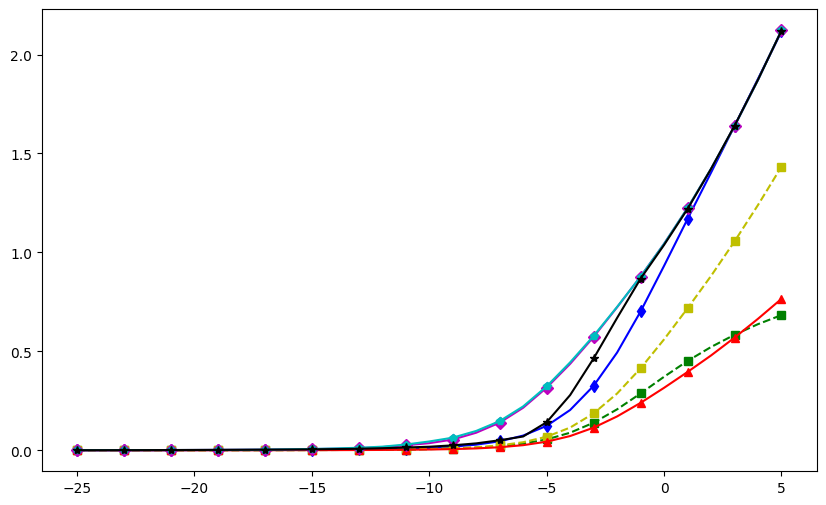

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis, skew
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

# ---------------------
# 1) System Parameters
# ---------------------
SNR_dB = np.arange(-25, 6, 1)
SNR_linear = 10**(SNR_dB / 10)
h_u1_2, h_u2_2, h_oma_2 = 0.65, 2.7, 0.6
alpha1, alpha2 = 0.8, 0.2
Ns, sigma_n2, alpha_cyclic = 50, 1.0, 0.1
Pf_u1 = Pf_u2 = Pf_oma = 0.10
M1 = M2 = 2
num_samples = 10000
test_size = 0.2
cyclic_lags = [18, 15]

# ---------------------
# 2) Cyclic Correlation Detection
# ---------------------
def compute_cyclic_threshold(Pf, Ns, sigma_n2):
    return np.sqrt(2 * sigma_n2 / Ns) * norm.ppf(1 - Pf)

def cyclic_correlation_pd(SNR, alpha, h_2, Ns, lambda_val, sigma_n2, alpha_cyclic):
    signal_power = alpha * h_2 * SNR
    var_cyclic_H1 = (sigma_n2 + signal_power)**2 / Ns
    return 1 - norm.cdf((lambda_val - signal_power) / np.sqrt(var_cyclic_H1))

# ---------------------
# 3) ML Classifiers
# ---------------------
def generate_ml_data(snr_lin, num_samples):
    X, y = [], []
    for _ in range(num_samples):
        signal_present = np.random.rand() > 0.5
        if signal_present:
            x_u1 = np.sqrt(alpha1 * h_u1_2 * snr_lin) * np.random.randn(Ns)
            x_u2 = np.sqrt(alpha2 * h_u2_2 * snr_lin) * np.random.randn(Ns)
            signal = x_u1 + x_u2
        else:
            signal = np.zeros(Ns)
        noise = np.sqrt(sigma_n2 / 2) * (np.random.randn(Ns) + 1j * np.random.randn(Ns))
        received = signal + noise
        mag = np.abs(received)
        
        # CAF features
        caf_values = []
        for lag in cyclic_lags:
            if lag < Ns:
                caf = np.mean(received[:-lag] * np.conj(received[lag:]))
                caf_values.append(np.abs(caf))
        caf_peak = max(caf_values) if caf_values else 0.0
        caf_variance = np.var(caf_values) if len(caf_values) > 1 else 0.0
        
        # Signal power
        signal_power = max(np.mean(mag ** 2) - sigma_n2, 0)
        
        # Statistical features
        mag_kurtosis = kurtosis(mag)
        mag_skewness = skew(mag)
        
        features = [
            np.mean(mag), np.std(mag), np.sum(mag**2),
            np.percentile(mag, 25), np.percentile(mag, 75),
            caf_peak, caf_variance, signal_power,
            mag_kurtosis, mag_skewness
        ]
        X.append(features)
        y.append(signal_present)
    return np.array(X), np.array(y)

def train_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
        'SVM': SVC(probability=True, random_state=42)
    }
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_probs = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        results[name] = (fpr, tpr, roc_auc)
    return results

# ---------------------
# 4) Throughput Calculation
# ---------------------
def calc_noma_rate_user(alpha, h_2, snr, interference_alpha, interference_h_2):
    numerator = alpha * h_2 * snr
    denominator = (interference_alpha * interference_h_2 * snr + sigma_n2)
    return np.log2(1 + numerator / denominator)

def calc_oma_rate(h_oma_2, snr):
    return 0.5 * np.log2(1 + (h_oma_2 * snr) / sigma_n2)

# ---------------------
# 5) Simulation Loop
# ---------------------
results_dict = {
    'Pd_u1': [], 'Pd_u2': [], 'Pd_oma': [],
    'Pd_rf': [], 'Pd_lr': [], 'Pd_dt': [], 'Pd_xgb': [], 'Pd_svm': [],
    'th_noma_u1': [], 'th_noma_u2': [], 'th_noma_total': [],
    'th_oma': [], 'th_noma_rf': [], 'th_noma_lr': [], 'th_noma_dt': [],
    'th_noma_xgb': [], 'th_noma_svm': []
}

for snr_db, snr_lin in zip(SNR_dB, SNR_linear):
    lambda_noma = compute_cyclic_threshold(Pf_u1, Ns, sigma_n2)
    lambda_oma = compute_cyclic_threshold(Pf_oma, Ns, sigma_n2)

    pd_u1 = cyclic_correlation_pd(snr_lin, alpha1, h_u1_2, Ns, lambda_noma, sigma_n2, alpha_cyclic)
    pd_u2 = cyclic_correlation_pd(snr_lin, alpha2, h_u2_2, Ns, lambda_noma, sigma_n2, alpha_cyclic)
    pd_oma = cyclic_correlation_pd(snr_lin, 1.0, h_oma_2, Ns, lambda_oma, sigma_n2, alpha_cyclic)

    X, y = generate_ml_data(snr_lin, num_samples)
    results = train_classifiers(X, y)
    fpr_target = 0.10
    pd_results = {
        name: float(interp1d(fpr, tpr)(fpr_target)) if max(fpr) >= fpr_target else 1.0
        for name, (fpr, tpr, _) in results.items()
    }

    rate_u1 = calc_noma_rate_user(alpha1, h_u1_2, snr_lin, alpha2, h_u2_2)
    rate_u2 = calc_noma_rate_user(alpha2, h_u2_2, snr_lin, 0, 0)
    rate_oma = calc_oma_rate(h_oma_2, snr_lin)

    results_dict['Pd_u1'].append(pd_u1)
    results_dict['Pd_u2'].append(pd_u2)
    results_dict['Pd_oma'].append(pd_oma)
    results_dict['Pd_rf'].append(pd_results['Random Forest'])
    results_dict['Pd_lr'].append(pd_results['Logistic Regression'])
    results_dict['Pd_dt'].append(pd_results['Decision Tree'])
    results_dict['Pd_xgb'].append(pd_results['XGBoost'])
    results_dict['Pd_svm'].append(pd_results['SVM'])

    results_dict['th_noma_u1'].append(pd_u1 * rate_u1)
    results_dict['th_noma_u2'].append(pd_u2 * rate_u2)
    results_dict['th_noma_total'].append(pd_u1 * rate_u1 + pd_u2 * rate_u2)
    results_dict['th_oma'].append(pd_oma * rate_oma)
    results_dict['th_noma_rf'].append(pd_results['Random Forest'] * (rate_u1 + rate_u2))
    results_dict['th_noma_lr'].append(pd_results['Logistic Regression'] * (rate_u1 + rate_u2))
    results_dict['th_noma_dt'].append(pd_results['Decision Tree'] * (rate_u1 + rate_u2))
    results_dict['th_noma_xgb'].append(pd_results['XGBoost'] * (rate_u1 + rate_u2))
    results_dict['th_noma_svm'].append(pd_results['SVM'] * (rate_u1 + rate_u2))

# ---------------------
# 6) Smooth and Plot
# ---------------------
window_length, polyorder = 7, 2
smoothed_curves = {
    key: savgol_filter(results_dict[key], window_length, polyorder)
    for key in results_dict if key.startswith('th_')
}

plt.figure(figsize=(10, 6))
plt.plot(SNR_dB, smoothed_curves['th_noma_total'], 'b-d', label='NOMA Total (Cyclic)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_u1'], 'g--s', label='NOMA-U1 (Cyclic)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_u2'], 'y--s', label='NOMA-U2 (Cyclic)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_oma'], 'r-^', label='OMA (Cyclic)', markevery=2)

# FIX: Use `color=` for named colors
plt.plot(SNR_dB, smoothed_curves['th_noma_rf'], 'm-D', label='NOMA (Random Forest)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_lr'], 'c-p', label='NOMA (Logistic Regression)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_dt'], 'k-*', label='NOMA (Decision Tree)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_xgb'], marker='x', linestyle='-', color='orange', label='NOMA (XGBoost)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_svm'], marker='v', linestyle='-', color='purple', label='NOMA (SVM)', markevery=2)

plt.xlabel('SNR (dB)')
plt.ylabel('Effective Throughput (bps/Hz)')
plt.title('Throughput Performance: NOMA vs OMA with Cyclic and ML Detection (Smoothed)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('noma_oma_ml_throughput_comparison_smooth.png', dpi=300)
plt.show()

# ---------------------
# 7) Print 0 dB Analysis
# ---------------------
idx_0dB = np.where(SNR_dB == 0)[0][0]
print("\nThroughput at SNR = 0 dB (Original Data):")
print(f"NOMA U1 (Cyclic): {results_dict['th_noma_u1'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA U2 (Cyclic): {results_dict['th_noma_u2'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA Total (Cyclic): {results_dict['th_noma_total'][idx_0dB]:.4f} bps/Hz")
print(f"OMA (Cyclic): {results_dict['th_oma'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA (Random Forest): {results_dict['th_noma_rf'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA (Logistic Regression): {results_dict['th_noma_lr'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA (Decision Tree): {results_dict['th_noma_dt'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA (XGBoost): {results_dict['th_noma_xgb'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA (SVM): {results_dict['th_noma_svm'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA Total (Cyclic)/OMA Ratio: {results_dict['th_noma_total'][idx_0dB] / results_dict['th_oma'][idx_0dB]:.4f}")